## Importaciones

Importar todas las bibliotecas y funciones necesarias para el análisis de datos, preprocesamiento, modelado y evaluación.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


## Carga Datos
Carga del conjunto de datos procesados ​​desde un archivo CSV.

In [2]:
data = pd.read_csv('../data/stroke_dataset_processed.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3364 entries, 0 to 3363
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3364 non-null   object 
 1   age                3364 non-null   float64
 2   hypertension       3364 non-null   int64  
 3   heart_disease      3364 non-null   int64  
 4   avg_glucose_level  3364 non-null   float64
 5   smoking_status     3364 non-null   object 
 6   stroke             3364 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 184.1+ KB


## Preparación de datos
Separar las características (X) y la variable objetivo (y)

In [3]:
X = data.drop('stroke', axis=1)
y = data['stroke']

## División de datos
Divide los datos en conjuntos de entrenamiento, validación y prueba

In [4]:
# Primero, separamos los datos de prueba final
X_temp, X_test_final, y_temp, y_test_final = train_test_split(X, y, test_size=0.1, random_state=42)

# Luego, dividimos el resto en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Guardar la muestra de prueba final
test_final_data = pd.concat([X_test_final, y_test_final], axis=1)
test_final_data.to_csv('test_final_sample.csv', index=False)

print("Tamaño del conjunto de entrenamiento:", X_train.shape[0])
print("Tamaño del conjunto de validación:", X_val.shape[0])
print("Tamaño del conjunto de prueba final:", X_test_final.shape[0])


Tamaño del conjunto de entrenamiento: 2421
Tamaño del conjunto de validación: 606
Tamaño del conjunto de prueba final: 337


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Identificación de tipos de características
Identifica las columnas numéricas y categóricas en el conjunto de datos.

In [6]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

## Creación de preprocesadores
Crea pipelines de preprocesamiento para características numéricas y categóricas

In [7]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Definición de modelos
Define los modelos a comparar.

In [8]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

# Función para graficar la matriz de confusión
Función para visualizar la matriz de confusión.

In [9]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predicho')
    plt.show()

## Función para calcular overfitting

In [10]:
def calculate_overfitting(model, X_train, y_train, X_val, y_val):
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    val_accuracy = accuracy_score(y_val, model.predict(X_val))
    overfitting = train_accuracy - val_accuracy
    return overfitting

## Comparación de modelos
Entrena y evalúa cada modelo, guardando el mejor.


Logistic Regression:
Accuracy: 0.7455
Precision: 0.2110
F1-Score: 0.3359
ROC-AUC: 0.8648
Overfitting: -0.0523
Precisión media en validación cruzada: 0.6946
Desviación estándar en validación cruzada: 0.0039


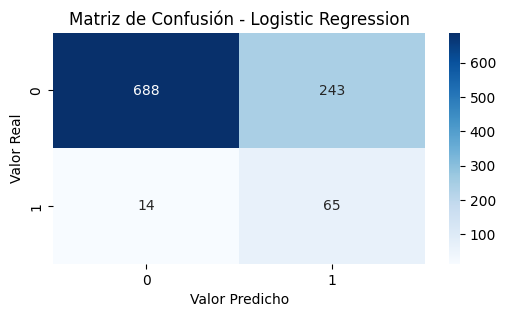


Random Forest:
Accuracy: 0.8238
Precision: 0.1633
F1-Score: 0.2124
ROC-AUC: 0.7284
Overfitting: 0.1762
Precisión media en validación cruzada: 0.8305
Desviación estándar en validación cruzada: 0.0123


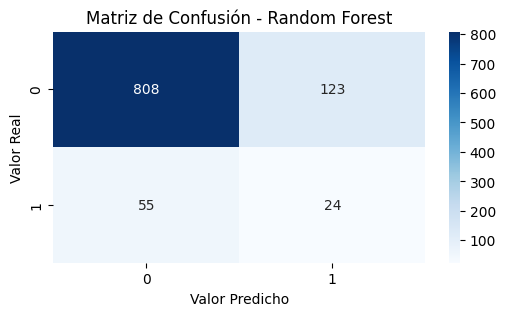


XGBoost:
Accuracy: 0.8673
Precision: 0.2165
F1-Score: 0.2386
ROC-AUC: 0.7339
Overfitting: 0.1025
Precisión media en validación cruzada: 0.8462
Desviación estándar en validación cruzada: 0.0195


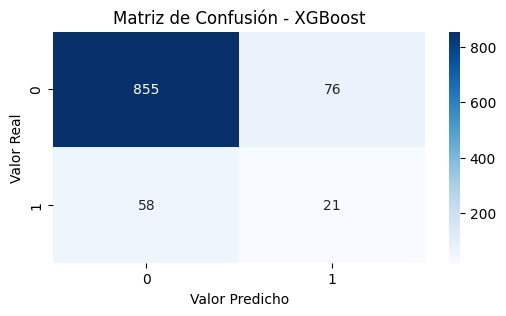


CatBoost:
Accuracy: 0.8960
Precision: 0.2969
F1-Score: 0.2657
ROC-AUC: 0.7420
Overfitting: 0.0445
Precisión media en validación cruzada: 0.8683
Desviación estándar en validación cruzada: 0.0134


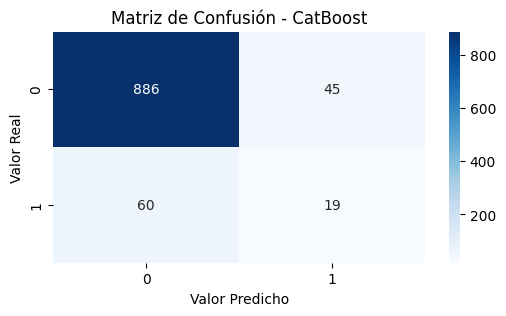

In [11]:
# Comparar modelos
best_model = None
best_accuracy = 0
best_model_name = ''

for name, model in models.items():
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    # Evaluar en el conjunto de validación
    val_pred = pipeline.predict(X_val)
    val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    
    val_accuracy = accuracy_score(y_val, val_pred)
    val_precision = precision_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    val_roc_auc = roc_auc_score(y_val, val_pred_proba)
    
    # Calcular overfitting
    overfitting = calculate_overfitting(pipeline, X_train, y_train, X_val, y_val)
    
    print(f"\n{name}:")
    print(f"Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"F1-Score: {val_f1:.4f}")
    print(f"ROC-AUC: {val_roc_auc:.4f}")
    print(f"Overfitting: {overfitting:.4f}")
    
    # Realizar validación cruzada
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    print(f"Precisión media en validación cruzada: {cv_scores.mean():.4f}")
    print(f"Desviación estándar en validación cruzada: {cv_scores.std():.4f}")
    
    # Plotear matriz de confusión
    plot_confusion_matrix(y_val, val_pred, f'Matriz de Confusión - {name}')
    
    # Actualizar el mejor modelo si es necesario
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = pipeline
        best_model_name = name

## Evaluación del mejor modelo
Evalúa el mejor modelo en el conjunto de prueba y muestra los resultados

In [12]:
def print_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{title}")
    print(cm)
    print(f"Verdaderos Negativos: {cm[0,0]}")
    print(f"Falsos Positivos: {cm[0,1]}")
    print(f"Falsos Negativos: {cm[1,0]}")
    print(f"Verdaderos Positivos: {cm[1,1]}")

In [13]:
# Evaluar el mejor modelo en el conjunto de prueba
test_pred = best_model.predict(X_val)
test_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Calcular métricas
test_accuracy = accuracy_score(y_val, test_pred)
test_precision = precision_score(y_val, test_pred)
test_f1 = f1_score(y_val, test_pred)
test_roc_auc = roc_auc_score(y_val, test_pred_proba)

# Imprimir resultados
print("\nMejor modelo:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")

print("\nInforme de clasificación:")
print(classification_report(y_val, test_pred))

# Plotear matriz de confusión para el mejor modelo
print_confusion_matrix(y_val, test_pred, f'Matriz de Confusión - Mejor Modelo ({best_model_name})')

# Guardar el mejor modelo
joblib.dump(best_model, f'best_model_{best_model_name}.joblib')


Mejor modelo:
Accuracy: 0.8960
Precision: 0.2969
F1-Score: 0.2657
ROC-AUC: 0.7420

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       931
           1       0.30      0.24      0.27        79

    accuracy                           0.90      1010
   macro avg       0.62      0.60      0.60      1010
weighted avg       0.89      0.90      0.89      1010


Matriz de Confusión - Mejor Modelo (CatBoost)
[[886  45]
 [ 60  19]]
Verdaderos Negativos: 886
Falsos Positivos: 45
Falsos Negativos: 60
Verdaderos Positivos: 19


['best_model_CatBoost.joblib']

## Cálculo de métricas adicionales
Calcula y visualiza métricas adicionales como la curva ROC, sensibilidad, especificidad y la curva de Precision-Recall.

Precision-Recall AUC: 0.2117


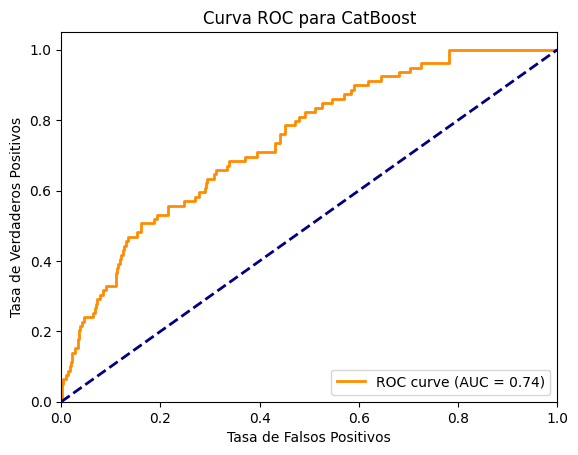

Sensibilidad (Recall de la clase positiva): 0.2405
Especificidad: 0.9517


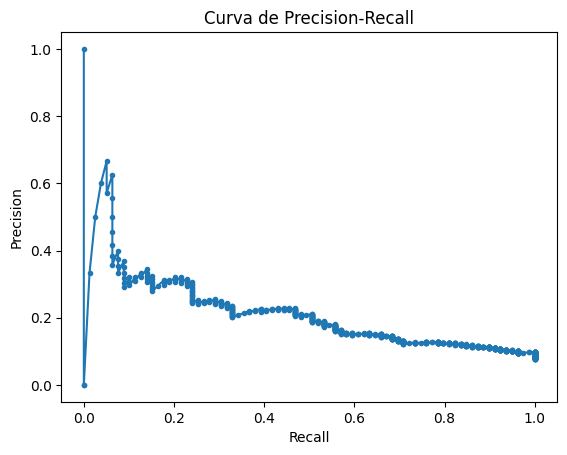

In [14]:
# Calcular Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_val, test_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Calcular y graficar la curva ROC
fpr, tpr, thresholds = roc_curve(y_val, test_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title(f'Curva ROC para {best_model_name}')
plt.legend(loc="lower right")
plt.show()

# Calcular Sensibilidad y Especificidad
tn, fp, fn, tp = confusion_matrix(y_val, test_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensibilidad (Recall de la clase positiva): {sensitivity:.4f}")
print(f"Especificidad: {specificity:.4f}")

# Visualizar la curva de Precision-Recall
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precision-Recall')
plt.show()

## Evaluación de diferentes umbrales
Evalúa el rendimiento del modelo con diferentes umbrales de decisión.

In [15]:
# Ajustar el umbral de clasificación
y_pred_proba = best_model.predict_proba(X_val)[:, 1]
thresholds = [0.3, 0.4, 0.5]
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(f"\nUmbral: {threshold}")
    print_confusion_matrix(y_val, y_pred, f'Matriz de Confusión - Umbral {threshold}')


Umbral: 0.3

Matriz de Confusión - Umbral 0.3
[[758 173]
 [ 39  40]]
Verdaderos Negativos: 758
Falsos Positivos: 173
Falsos Negativos: 39
Verdaderos Positivos: 40

Umbral: 0.4

Matriz de Confusión - Umbral 0.4
[[843  88]
 [ 53  26]]
Verdaderos Negativos: 843
Falsos Positivos: 88
Falsos Negativos: 53
Verdaderos Positivos: 26

Umbral: 0.5

Matriz de Confusión - Umbral 0.5
[[886  45]
 [ 60  19]]
Verdaderos Negativos: 886
Falsos Positivos: 45
Falsos Negativos: 60
Verdaderos Positivos: 19


In [16]:
# Experimentar con diferentes umbrales de decisión
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

print("\nEvaluación de diferentes umbrales de decisión:")
for threshold in thresholds:
    y_pred = (test_pred_proba >= threshold).astype(int)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    print(f"Umbral: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


Evaluación de diferentes umbrales de decisión:
Umbral: 0.30, Precision: 0.1878, Recall: 0.5063
Umbral: 0.40, Precision: 0.2281, Recall: 0.3291
Umbral: 0.50, Precision: 0.2969, Recall: 0.2405
Umbral: 0.60, Precision: 0.3214, Recall: 0.1139
Umbral: 0.70, Precision: 0.3846, Recall: 0.0633


## Cálculo del sobreajuste
Calcula el overfitting y verifica si cumple con el criterio establecido.

In [17]:
# Calcular el overfitting
train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
overfitting = train_accuracy - test_accuracy

print(f"\nOverfitting: {overfitting:.4f}")

# Verificar si el overfitting es menor al 5%
if overfitting < 0.05:
    print("El modelo cumple con el criterio de overfitting menor al 5%.")
else:
    print("El modelo no cumple con el criterio de overfitting menor al 5%.")


Overfitting: 0.0445
El modelo cumple con el criterio de overfitting menor al 5%.



Rendimiento en el conjunto de prueba final:
Accuracy: 0.9347
Precision: 0.2667
F1-Score: 0.2667
ROC-AUC: 0.7915

Informe de clasificación en el conjunto de prueba final:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       322
           1       0.27      0.27      0.27        15

    accuracy                           0.93       337
   macro avg       0.62      0.62      0.62       337
weighted avg       0.93      0.93      0.93       337



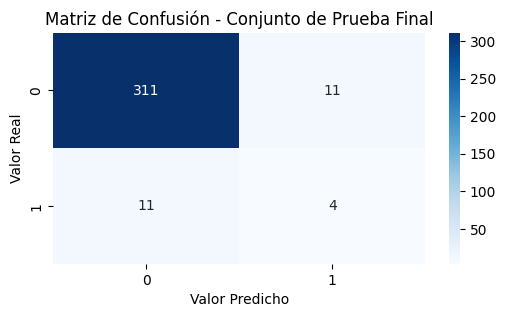

In [18]:
# Cargar los datos de prueba final
test_final_data = pd.read_csv('test_final_sample.csv')
X_test_final = test_final_data.drop('stroke', axis=1)
y_test_final = test_final_data['stroke']

# Evaluar el mejor modelo en el conjunto de prueba final
final_pred = best_model.predict(X_test_final)
final_pred_proba = best_model.predict_proba(X_test_final)[:, 1]

final_accuracy = accuracy_score(y_test_final, final_pred)
final_precision = precision_score(y_test_final, final_pred)
final_f1 = f1_score(y_test_final, final_pred)
final_roc_auc = roc_auc_score(y_test_final, final_pred_proba)

print("\nRendimiento en el conjunto de prueba final:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"ROC-AUC: {final_roc_auc:.4f}")

print("\nInforme de clasificación en el conjunto de prueba final:")
print(classification_report(y_test_final, final_pred))

# Plotear matriz de confusión para el conjunto de prueba final
plot_confusion_matrix(y_test_final, final_pred, 'Matriz de Confusión - Conjunto de Prueba Final')

## Buscar mejores hiperparámetro
El modelo no clasifica bien la clase minoritaría, por lo cual usamos la búsqueda de hiperparámetros para intentar mejorar la clasificación

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score

## Definir un espacio de búsqueda de hiperparámetros


In [20]:
param_dist = {
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__depth': [4, 6, 8, 10],
    'classifier__l2_leaf_reg': [1, 3, 5, 7, 9],
    'classifier__iterations': [100, 200, 300],
    'classifier__scale_pos_weight': [1, 5, 10]
}

## Crea un pipeline que incluye el preprocesamiento y el modelo CatBoost

In [21]:
catboost_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', CatBoostClassifier(verbose=0, random_state=42))
])


## Definir métricas de evaluación

In [22]:
scoring = {
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'accuracy': 'accuracy'
}

## Configurar y ejecutar la búsqueda aleatoria de hiperparámetros

In [23]:
random_search = RandomizedSearchCV(
    catboost_pipeline,
    param_distributions=param_dist,
    n_iter=20,  # Número de combinaciones de parámetros a probar
    cv=5,  # Número de pliegues para validación cruzada
    scoring=scoring,
    refit='f1',  # Métrica para seleccionar el mejor modelo
    n_jobs=-1,  # Usar todos los núcleos disponibles
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level'], dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')...
                   param_distributions={'classifier__depth': [4, 6, 8, 10],
                                        'classifier__iterations': [100, 200,
                                                                   300],
                                        'classifier__l2_leaf_reg': [1, 3, 5, 7,
                                                                    9],
                                        'classifier__learning_rate': [0.01,
                                                                      0.05,
                                                                      0.1],
                                        'classifier__scale_pos_weight': [1, 5,
                                                                         10]},
                   random_state=42, refit='f1',
                   scoring={'accuracy': 'accuracy',
                            'f1': make_scorer(f1_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=1)

## Imprime los mejores parámetros y resultados

In [24]:
print("Mejores parámetros encontrados:")
print(random_search.best_params_)
print("\nMejores puntuaciones:")
print(f"F1-score: {random_search.best_score_:.4f}")
print(f"Recall: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]:.4f}")
print(f"Accuracy: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]:.4f}")

Mejores parámetros encontrados:
{'classifier__scale_pos_weight': 1, 'classifier__learning_rate': 0.01, 'classifier__l2_leaf_reg': 7, 'classifier__iterations': 100, 'classifier__depth': 8}

Mejores puntuaciones:
F1-score: 0.2376
Recall: 0.7549
Accuracy: 0.6551


## Evaluar el mejor modelo en el conjunto de prueba

In [25]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

print("\nRendimiento en el conjunto de prueba:")
print(f"F1-score: {f1_score(y_val, y_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_proba):.4f}")

print("\nMatriz de confusión:")
print_confusion_matrix(y_val, y_pred, "Mejor modelo CatBoost")


Rendimiento en el conjunto de prueba:
F1-score: 0.3063
Recall: 0.8861
Accuracy: 0.6861
ROC-AUC: 0.8416

Matriz de confusión:

Mejor modelo CatBoost
[[623 308]
 [  9  70]]
Verdaderos Negativos: 623
Falsos Positivos: 308
Falsos Negativos: 9
Verdaderos Positivos: 70


In [26]:
param_dist = {
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__depth': [4, 6, 8, 10, 12],
    'classifier__l2_leaf_reg': [1, 3, 5, 7, 9],
    'classifier__iterations': [100, 200, 300, 500],
    'classifier__scale_pos_weight': [1, 5, 10, 20],
    'classifier__border_count': [32, 64, 128],  # Aumentar número de divisiones para la discretización
    'classifier__subsample': [0.6, 0.8, 1.0],  # Submuestreo de filas para mejorar la generalización
    'classifier__colsample_bylevel': [0.6, 0.8, 1.0]  # Submuestreo de columnas para evitar sobreajuste
}


In [27]:
random_search = RandomizedSearchCV(
    catboost_pipeline,
    param_distributions=param_dist,
    n_iter=30,  # Aumenta el número de iteraciones para explorar más combinaciones
    cv=5,
    scoring=scoring,
    refit='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level'], dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')...
                                        'classifier__l2_leaf_reg': [1, 3, 5, 7,
                                                                    9],
                                        'classifier__learning_rate': [0.01,
                                                                      0.05, 0.1,
                                                                      0.2],
                                        'classifier__scale_pos_weight': [1, 5,
                                                                         10,
                                                                         20],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0]},
                   random_state=42, refit='f1',
                   scoring={'accuracy': 'accuracy',
                            'f1': make_scorer(f1_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=1)

In [28]:
print("Mejores parámetros encontrados:")
print(random_search.best_params_)
print("\nMejores puntuaciones:")
print(f"F1-score: {random_search.best_score_:.4f}")
print(f"Recall: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]:.4f}")
print(f"Accuracy: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]:.4f}")

Mejores parámetros encontrados:
{'classifier__subsample': 1.0, 'classifier__scale_pos_weight': 1, 'classifier__learning_rate': 0.01, 'classifier__l2_leaf_reg': 3, 'classifier__iterations': 300, 'classifier__depth': 8, 'classifier__colsample_bylevel': 0.6, 'classifier__border_count': 64}

Mejores puntuaciones:
F1-score: 0.2252
Recall: 0.4968
Accuracy: 0.7583


In [29]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

print("\nRendimiento en el conjunto de prueba:")
print(f"F1-score: {f1_score(y_val, y_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_proba):.4f}")

print("\nMatriz de confusión:")
print_confusion_matrix(y_val, y_pred, "Mejor modelo CatBoost")

# Guardar el mejor modelo
joblib.dump(best_model, f'best_model_{best_model_name}_hiper.joblib')


Rendimiento en el conjunto de prueba:
F1-score: 0.2961
Recall: 0.6203
Accuracy: 0.7693
ROC-AUC: 0.7758

Matriz de confusión:

Mejor modelo CatBoost
[[728 203]
 [ 30  49]]
Verdaderos Negativos: 728
Falsos Positivos: 203
Falsos Negativos: 30
Verdaderos Positivos: 49


['best_model_CatBoost_hiper.joblib']